In [1]:
# !nvcc --version

In [2]:
# !nvidia-smi

**DOWNLOAD & LOAD THE DATASET**

In [3]:
!pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ashfaaqahamed","key":"86e89dc41b42ce98d2ce0e2198cec3e2"}'}

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/ 
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d wwwwwee/dehaze

100% 1.78G/1.78G [01:34<00:00, 21.9MB/s]
100% 1.78G/1.78G [01:34<00:00, 20.2MB/s]


In [7]:
! unzip dehaze.zip

Streaming output truncated to the last 5000 lines.
  inflating: haze/0698_0.85_0.16.jpg  
  inflating: haze/0698_0.85_0.2.jpg  
  inflating: haze/0698_0.8_0.04.jpg  
  inflating: haze/0698_0.8_0.06.jpg  
  inflating: haze/0698_0.8_0.08.jpg  
  inflating: haze/0698_0.8_0.1.jpg   
  inflating: haze/0698_0.8_0.12.jpg  
  inflating: haze/0698_0.8_0.16.jpg  
  inflating: haze/0698_0.8_0.2.jpg   
  inflating: haze/0698_0.95_0.04.jpg  
  inflating: haze/0698_0.95_0.06.jpg  
  inflating: haze/0698_0.95_0.08.jpg  
  inflating: haze/0698_0.95_0.1.jpg  
  inflating: haze/0698_0.95_0.12.jpg  
  inflating: haze/0698_0.95_0.16.jpg  
  inflating: haze/0698_0.95_0.2.jpg  
  inflating: haze/0698_0.9_0.04.jpg  
  inflating: haze/0698_0.9_0.06.jpg  
  inflating: haze/0698_0.9_0.08.jpg  
  inflating: haze/0698_0.9_0.1.jpg   
  inflating: haze/0698_0.9_0.12.jpg  
  inflating: haze/0698_0.9_0.16.jpg  
  inflating: haze/0698_0.9_0.2.jpg   
  inflating: haze/0698_1_0.04.jpg    
  inflating: haze/0698_1_0.06.j

In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

Create new directories for the training and validation sets:

In [9]:
import os

base_dir = '/content'
train_hazy_dir = os.path.join(base_dir, 'train/hazy')
train_clear_dir = os.path.join(base_dir, 'train/clear')
val_hazy_dir = os.path.join(base_dir, 'val/hazy')
val_clear_dir = os.path.join(base_dir, 'val/clear')

os.makedirs(train_hazy_dir, exist_ok=True)
os.makedirs(train_clear_dir, exist_ok=True)
os.makedirs(val_hazy_dir, exist_ok=True)
os.makedirs(val_clear_dir, exist_ok=True)

Split the original dataset into training and validation sets:

In [10]:
import shutil
from sklearn.model_selection import train_test_split

hazy_dir = os.path.join(base_dir, 'haze')
clear_dir = os.path.join(base_dir, 'clear_images')
hazy_files = sorted(os.listdir(hazy_dir))
clear_files = sorted(os.listdir(clear_dir))

clear_train_files, clear_val_files = train_test_split(clear_files, test_size=0.2, random_state=42)

for clear_file in clear_files:
    clear_id = os.path.splitext(clear_file)[0]
    matched_hazy_files = [hazy_file for hazy_file in hazy_files if hazy_file.startswith(clear_id + '_')]
    
    if clear_file in clear_train_files:
        shutil.copy(os.path.join(clear_dir, clear_file), os.path.join(train_clear_dir, clear_file))
        for matched_hazy_file in matched_hazy_files:
            shutil.copy(os.path.join(hazy_dir, matched_hazy_file), os.path.join(train_hazy_dir, matched_hazy_file))
    else:
        shutil.copy(os.path.join(clear_dir, clear_file), os.path.join(val_clear_dir, clear_file))
        for matched_hazy_file in matched_hazy_files:
            shutil.copy(os.path.join(hazy_dir, matched_hazy_file), os.path.join(val_hazy_dir, matched_hazy_file))


In [11]:
def reside_data_generator(hazy_dir, clear_dir, batch_size, img_size, shuffle=True):
    hazy_files = sorted(os.listdir(hazy_dir))
    clear_files = sorted(os.listdir(clear_dir))

    file_mapping = []
    for clear_file in clear_files:
        clear_id = os.path.splitext(clear_file)[0]
        matched_hazy_files = [hazy_file for hazy_file in hazy_files if hazy_file.startswith(clear_id + '_')]
        for matched_hazy_file in matched_hazy_files:
            file_mapping.append((matched_hazy_file, clear_file))

    if shuffle:
        np.random.shuffle(file_mapping)

    while True:
        for i in range(0, len(file_mapping), batch_size):
            batch_files = file_mapping[i:i+batch_size]
            batch_hazy_imgs = []
            batch_clear_imgs = []

            for hazy_file, clear_file in batch_files:
                hazy_img = Image.open(os.path.join(hazy_dir, hazy_file)).resize(img_size)
                clear_img = Image.open(os.path.join(clear_dir, clear_file)).resize(img_size)

                hazy_img = np.array(hazy_img) / 127.5 - 1.0
                clear_img = np.array(clear_img) / 127.5 - 1.0

                batch_hazy_imgs.append(hazy_img)
                batch_clear_imgs.append(clear_img)

            yield np.array(batch_hazy_imgs), np.array(batch_clear_imgs)


In [12]:
batch_size = 16
img_size = (256, 256)

# train_gen = reside_data_generator("path/to/train/hazy", "path/to/train/clear", batch_size, img_size)
# val_gen = reside_data_generator("path/to/val/hazy", "path/to/val/clear", batch_size, img_size)
train_gen = reside_data_generator(train_hazy_dir, train_clear_dir, batch_size, img_size)
val_gen = reside_data_generator(val_hazy_dir, val_clear_dir, batch_size, img_size)


Generator and Discriminator architectures


In [13]:
def build_generator():
    inputs = tf.keras.layers.Input(shape=(256, 256, 3))
    k_init = tf.keras.initializers.glorot_uniform()
    b_init = tf.keras.initializers.zeros()
    regularizer = tf.keras.regularizers.l2(0.01)

    conv = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                  bias_initializer = b_init, kernel_regularizer = regularizer)(inputs)
    conv = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                  bias_initializer = b_init, kernel_regularizer = regularizer)(conv)

                                    #### Encoding Layers #####
    conv_up = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv)
    conv_up = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv_up)
                                    
                                    #### Residual Layers #####
    conv1_1 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                   bias_initializer = b_init, kernel_regularizer = regularizer)(conv_up)
    conv1_2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv1_1)
    conv1_3 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                   bias_initializer = b_init, kernel_regularizer = regularizer)(conv1_2)
    conc1 = tf.add(conv1_3, conv1_1)
    conv1 = tf.keras.activations.relu(conc1)

    conv2_1 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv1)
    conv2_2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv2_1)
    conv2_3 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv2_2)
    conc2 = tf.add(conv2_3, conv2_1)
    conv2 = tf.keras.activations.relu(conc2)

    conv3_1 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv2)
    conv3_2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_1)
    conv3_3 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_2)
    conv3_4 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_3)
    conv3_5 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_4)
    conc3 = tf.add(conv3_5, conv3_1)
    conv3 = tf.keras.activations.relu(conc3)

    conv4_1 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3)
    conv4_2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_1)
    conv4_3 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_2)
    conv4_4 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_3)
    conv4_5 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_4)
    conc4 = tf.add(conv4_5, conv4_1)
    conv4 = tf.keras.activations.relu(conc4)

                                            ##### Decoding Layers #####
    deconv = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                             kernel_regularizer = regularizer)(conv4)
    deconv = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                             kernel_regularizer = regularizer)(deconv)

    conv = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                  bias_initializer = b_init, kernel_regularizer = regularizer)(deconv)
    conv = tf.keras.layers.Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                  bias_initializer = b_init, kernel_regularizer = regularizer)(conv)
    conc = tf.add(conv, inputs)
    
    # output = tf.keras.activations.relu(conc)

    outputs = tf.keras.layers.experimental.preprocessing.Resizing(256, 256, interpolation='bilinear')(conc)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

def build_discriminator():
    input_hazy = tf.keras.layers.Input(shape=(256, 256, 3))
    input_clear = tf.keras.layers.Input(shape=(256, 256, 3))

    x = tf.keras.layers.concatenate([input_hazy, input_clear])

    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same', use_bias=False)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Conv2D(512, 4, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same')(x)

    return tf.keras.Model(inputs=[input_hazy, input_clear], outputs=x)

Create the generator and discriminator models and Define the GAN model, loss functions, and optimizers:

In [14]:
def build_combined_model(generator, discriminator):
    hazy_input = tf.keras.layers.Input(shape=(256, 256, 3))
    generated_image = generator(hazy_input)
    
    resized_hazy_input = tf.keras.layers.experimental.preprocessing.Resizing(256, 256, interpolation='bilinear')(hazy_input)
    resized_generated_image = tf.keras.layers.experimental.preprocessing.Resizing(256, 256, interpolation='bilinear')(generated_image)
    
    discriminator.trainable = False
    discriminator_output = discriminator([resized_hazy_input, resized_generated_image])

    return tf.keras.Model(inputs=hazy_input, outputs=[generated_image, discriminator_output])


generator = build_generator()
discriminator = build_discriminator()

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
l1_loss_object = tf.keras.losses.MeanAbsoluteError()

combined_model = build_combined_model(generator, discriminator)
combined_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                       loss=[l1_loss_object, loss_object],
                       loss_weights=[100, 1])

discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                      loss=loss_object)


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Implement the training loop. The training loop should include steps for training the discriminator and the generator:

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

def train_gan(train_gen, val_gen, num_epochs, steps_per_epoch, checkpoint_frequency=5):
    checkpoint_dir = './checkpoints'
    drive_dir = '/content/drive/My Drive/DehazeModels/TrainedOutdoor'
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    graph_disc_loss = []
    graph_gen_l1_loss = []
    graph_gen_adv_loss = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        epoch_disc_loss = []
        epoch_gen_l1_loss = []
        epoch_gen_adv_loss = []

        for step, (hazy_imgs, clear_imgs) in enumerate(train_gen):
            batch_size = hazy_imgs.shape[0]

            # Train the discriminator
            generated_imgs = generator.predict(hazy_imgs)
            real_labels = np.ones((batch_size, 32, 32, 1))
            fake_labels = np.zeros((batch_size, 32, 32, 1))

            real_loss = discriminator.train_on_batch([hazy_imgs, clear_imgs], real_labels)
            fake_loss = discriminator.train_on_batch([hazy_imgs, generated_imgs], fake_labels)
            disc_loss = 0.5 * (real_loss + fake_loss)
            epoch_disc_loss.append(disc_loss)

            # Train the generator (using the combined model)
            valid_labels = np.ones((batch_size, 32, 32, 1))
            combined_loss = combined_model.train_on_batch(hazy_imgs, [clear_imgs, valid_labels])
            epoch_gen_l1_loss.append(combined_loss[0])
            epoch_gen_adv_loss.append(combined_loss[1])

            if step >= steps_per_epoch - 1:
                break

        # Print epoch progress and any other metrics you'd like to track
        avg_disc_loss = np.mean(epoch_disc_loss)
        avg_gen_l1_loss = np.mean(epoch_gen_l1_loss)
        avg_gen_adv_loss = np.mean(epoch_gen_adv_loss)
        print(f"Discriminator loss: {avg_disc_loss:.4f}, Generator L1 loss: {avg_gen_l1_loss:.4f}, Generator adversarial loss: {avg_gen_adv_loss:.4f}")

        graph_disc_loss.append(avg_disc_loss)
        graph_gen_l1_loss.append(avg_gen_l1_loss)
        graph_gen_adv_loss.append(avg_gen_adv_loss)

        print("graph_disc_loss [] - ", graph_disc_loss)
        print("graph_gen_l1_loss [] - ", graph_gen_l1_loss)
        print("graph_gen_adv_loss [] - ", graph_gen_adv_loss)

        if (epoch + 1) % checkpoint_frequency == 0:

            # Plot the curves
            plt.plot(graph_disc_loss, 'r', label='Discriminator Loss')
            plt.plot(graph_gen_l1_loss, 'g', label='Generator L1 Loss')
            plt.plot(graph_gen_adv_loss, 'b', label='Generator Adversarial Loss')
            plt.legend()
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title(f'GAN Loss Curves (Epoch {epoch + 1})')
            plt.savefig(f'./loss_curves_epoch_{epoch + 1}.png')
            plt.show()

            # Save model weights at checkpoints
            checkpoint_path = os.path.join(checkpoint_dir, f'generator_{epoch + 1:04d}.h5')
            generator.save_weights(checkpoint_path)
            
            # Save model to drive
            drive_path = os.path.join(drive_dir, f'generator_{epoch + 1:04d}.h5')
            generator.save_weights(drive_path)

            print(f"Saved generator weights at {checkpoint_path}")

Mounted at /content/drive


Train the GAN using the generators:

Epoch 1/50
1/1 [==============================] - 0s 31ms/step
Discriminator loss: 0.6907, Generator L1 loss: 39.7648, Generator adversarial loss: 0.2429
graph_disc_loss [] -  [0.6906642019748688]
graph_gen_l1_loss [] -  [39.764784049987796]
graph_gen_adv_loss [] -  [0.24292135536670684]
Epoch 2/50
1/1 [==============================] - 0s 25ms/step
Discriminator loss: 0.6918, Generator L1 loss: 35.0286, Generator adversarial loss: 0.2024
graph_disc_loss [] -  [0.6906642019748688, 0.6918265253305436]
graph_gen_l1_loss [] -  [39.764784049987796, 35.02857360839844]
graph_gen_adv_loss [] -  [0.24292135536670684, 0.20241468101739885]
Epoch 3/50
1/1 [==============================] - 0s 25ms/step
Discriminator loss: 0.6920, Generator L1 loss: 30.4566, Generator adversarial loss: 0.1620
graph_disc_loss [] -  [0.6906642019748688, 0.6918265253305436, 0.6919991403818131]
graph_gen_l1_loss [] -  [39.764784049987796, 35.02857360839844, 30.45657596588135]
graph_gen_adv_loss [] -  [0.24292135536670

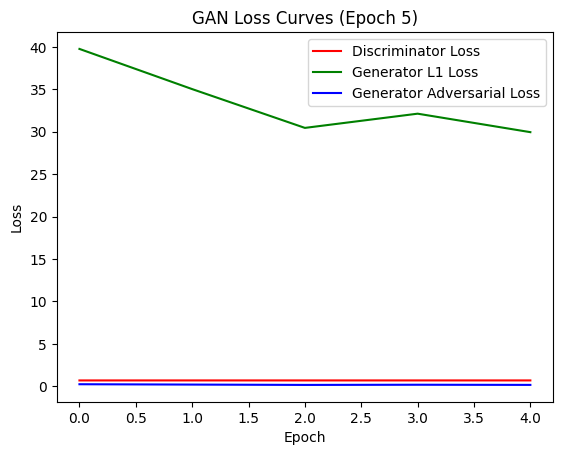

Saved generator weights at ./checkpoints/generator_0005.h5
Epoch 6/50
1/1 [==============================] - 0s 28ms/step
Discriminator loss: 0.6924, Generator L1 loss: 27.3775, Generator adversarial loss: 0.1427
graph_disc_loss [] -  [0.6906642019748688, 0.6918265253305436, 0.6919991403818131, 0.6917763769626617, 0.692221787571907, 0.6923738956451416]
graph_gen_l1_loss [] -  [39.764784049987796, 35.02857360839844, 30.45657596588135, 32.1319917678833, 29.95421199798584, 27.377450370788573]
graph_gen_adv_loss [] -  [0.24292135536670684, 0.20241468101739885, 0.16204436346888543, 0.18331498354673387, 0.16520702242851257, 0.14268381893634796]
Epoch 7/50
1/1 [==============================] - 0s 26ms/step
Discriminator loss: 0.6925, Generator L1 loss: 26.7456, Generator adversarial loss: 0.1393
graph_disc_loss [] -  [0.6906642019748688, 0.6918265253305436, 0.6919991403818131, 0.6917763769626617, 0.692221787571907, 0.6923738956451416, 0.6924831122159958]
graph_gen_l1_loss [] -  [39.764784049

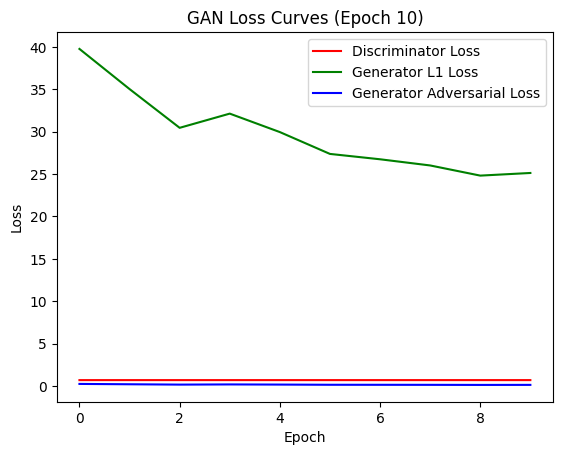

Saved generator weights at ./checkpoints/generator_0010.h5
Epoch 11/50
1/1 [==============================] - 0s 35ms/step
Discriminator loss: 0.6928, Generator L1 loss: 23.8984, Generator adversarial loss: 0.1200
graph_disc_loss [] -  [0.6906642019748688, 0.6918265253305436, 0.6919991403818131, 0.6917763769626617, 0.692221787571907, 0.6923738956451416, 0.6924831122159958, 0.6926120519638062, 0.6927804738283158, 0.6922833770513535, 0.6928440719842911]
graph_gen_l1_loss [] -  [39.764784049987796, 35.02857360839844, 30.45657596588135, 32.1319917678833, 29.95421199798584, 27.377450370788573, 26.745590209960938, 26.016627693176268, 24.818598365783693, 25.1293212890625, 23.898371505737305]
graph_gen_adv_loss [] -  [0.24292135536670684, 0.20241468101739885, 0.16204436346888543, 0.18331498354673387, 0.16520702242851257, 0.14268381893634796, 0.13930632025003434, 0.13460781723260878, 0.12495700642466545, 0.13023140877485276, 0.1199688658118248]
Epoch 12/50
1/1 [==============================] -

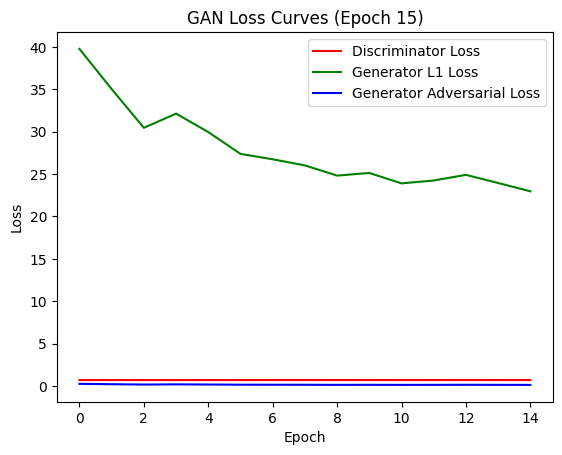

Saved generator weights at ./checkpoints/generator_0015.h5
Epoch 16/50
1/1 [==============================] - 0s 27ms/step
Discriminator loss: 0.6929, Generator L1 loss: 23.5091, Generator adversarial loss: 0.1246
graph_disc_loss [] -  [0.6906642019748688, 0.6918265253305436, 0.6919991403818131, 0.6917763769626617, 0.692221787571907, 0.6923738956451416, 0.6924831122159958, 0.6926120519638062, 0.6927804738283158, 0.6922833770513535, 0.6928440719842911, 0.6927037924528122, 0.6928390979766845, 0.692807424068451, 0.6928660839796066, 0.6928506463766098]
graph_gen_l1_loss [] -  [39.764784049987796, 35.02857360839844, 30.45657596588135, 32.1319917678833, 29.95421199798584, 27.377450370788573, 26.745590209960938, 26.016627693176268, 24.818598365783693, 25.1293212890625, 23.898371505737305, 24.24040355682373, 24.90433349609375, 23.94285659790039, 22.96446075439453, 23.509109878540038]
graph_gen_adv_loss [] -  [0.24292135536670684, 0.20241468101739885, 0.16204436346888543, 0.18331498354673387, 0

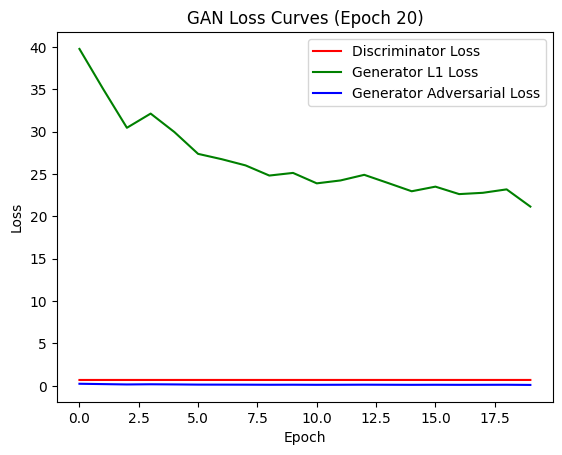

Saved generator weights at ./checkpoints/generator_0020.h5
Epoch 21/50
1/1 [==============================] - 0s 27ms/step
Discriminator loss: 0.6930, Generator L1 loss: 22.1138, Generator adversarial loss: 0.1172
graph_disc_loss [] -  [0.6906642019748688, 0.6918265253305436, 0.6919991403818131, 0.6917763769626617, 0.692221787571907, 0.6923738956451416, 0.6924831122159958, 0.6926120519638062, 0.6927804738283158, 0.6922833770513535, 0.6928440719842911, 0.6927037924528122, 0.6928390979766845, 0.692807424068451, 0.6928660839796066, 0.6928506463766098, 0.6928513497114182, 0.6929985791444778, 0.692814189195633, 0.692870357632637, 0.692996370792389]
graph_gen_l1_loss [] -  [39.764784049987796, 35.02857360839844, 30.45657596588135, 32.1319917678833, 29.95421199798584, 27.377450370788573, 26.745590209960938, 26.016627693176268, 24.818598365783693, 25.1293212890625, 23.898371505737305, 24.24040355682373, 24.90433349609375, 23.94285659790039, 22.96446075439453, 23.509109878540038, 22.62904453277

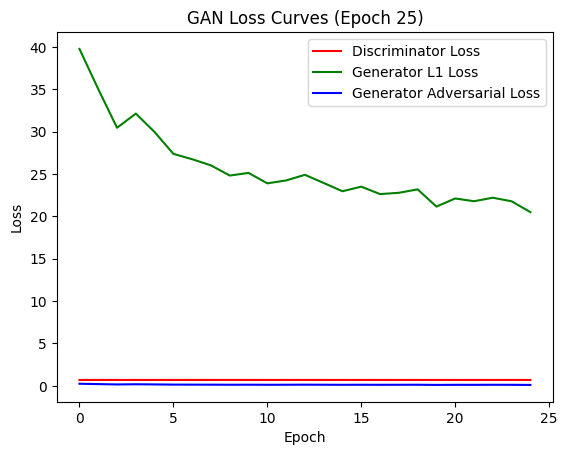

Saved generator weights at ./checkpoints/generator_0025.h5
Epoch 26/50
1/1 [==============================] - 0s 25ms/step
Discriminator loss: 0.6930, Generator L1 loss: 21.3517, Generator adversarial loss: 0.1147
graph_disc_loss [] -  [0.6906642019748688, 0.6918265253305436, 0.6919991403818131, 0.6917763769626617, 0.692221787571907, 0.6923738956451416, 0.6924831122159958, 0.6926120519638062, 0.6927804738283158, 0.6922833770513535, 0.6928440719842911, 0.6927037924528122, 0.6928390979766845, 0.692807424068451, 0.6928660839796066, 0.6928506463766098, 0.6928513497114182, 0.6929985791444778, 0.692814189195633, 0.692870357632637, 0.692996370792389, 0.6928769081830979, 0.6928954958915711, 0.6929234832525253, 0.6929999977350235, 0.6929589241743088]
graph_gen_l1_loss [] -  [39.764784049987796, 35.02857360839844, 30.45657596588135, 32.1319917678833, 29.95421199798584, 27.377450370788573, 26.745590209960938, 26.016627693176268, 24.818598365783693, 25.1293212890625, 23.898371505737305, 24.2404035

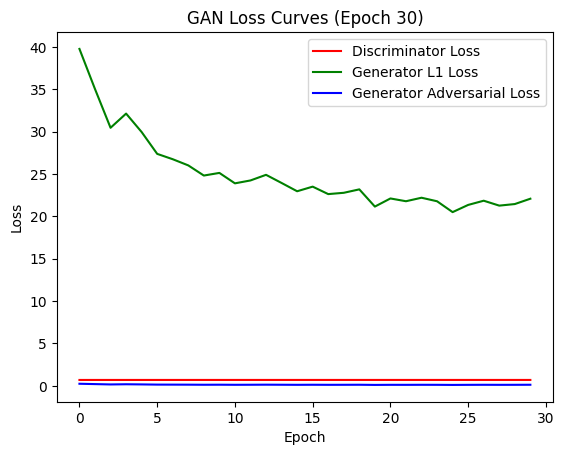

Saved generator weights at ./checkpoints/generator_0030.h5
Epoch 31/50
1/1 [==============================] - 0s 27ms/step
Discriminator loss: 0.6932, Generator L1 loss: 20.3747, Generator adversarial loss: 0.1091
graph_disc_loss [] -  [0.6906642019748688, 0.6918265253305436, 0.6919991403818131, 0.6917763769626617, 0.692221787571907, 0.6923738956451416, 0.6924831122159958, 0.6926120519638062, 0.6927804738283158, 0.6922833770513535, 0.6928440719842911, 0.6927037924528122, 0.6928390979766845, 0.692807424068451, 0.6928660839796066, 0.6928506463766098, 0.6928513497114182, 0.6929985791444778, 0.692814189195633, 0.692870357632637, 0.692996370792389, 0.6928769081830979, 0.6928954958915711, 0.6929234832525253, 0.6929999977350235, 0.6929589241743088, 0.6928619682788849, 0.6929273158311844, 0.6929279953241348, 0.6928247302770615, 0.6931536585092545]
graph_gen_l1_loss [] -  [39.764784049987796, 35.02857360839844, 30.45657596588135, 32.1319917678833, 29.95421199798584, 27.377450370788573, 26.74559

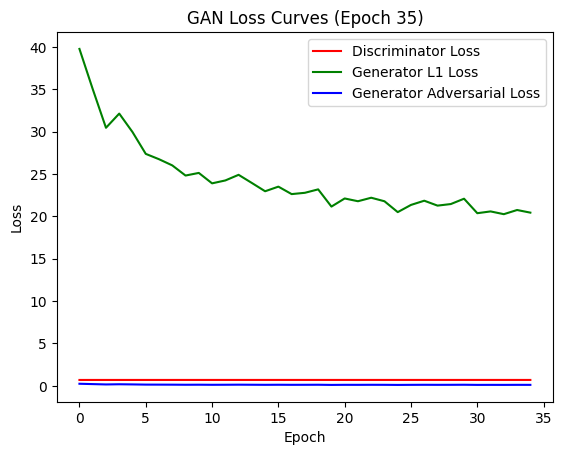

Saved generator weights at ./checkpoints/generator_0035.h5
Epoch 36/50
1/1 [==============================] - 0s 25ms/step
Discriminator loss: 0.6929, Generator L1 loss: 20.0367, Generator adversarial loss: 0.1093
graph_disc_loss [] -  [0.6906642019748688, 0.6918265253305436, 0.6919991403818131, 0.6917763769626617, 0.692221787571907, 0.6923738956451416, 0.6924831122159958, 0.6926120519638062, 0.6927804738283158, 0.6922833770513535, 0.6928440719842911, 0.6927037924528122, 0.6928390979766845, 0.692807424068451, 0.6928660839796066, 0.6928506463766098, 0.6928513497114182, 0.6929985791444778, 0.692814189195633, 0.692870357632637, 0.692996370792389, 0.6928769081830979, 0.6928954958915711, 0.6929234832525253, 0.6929999977350235, 0.6929589241743088, 0.6928619682788849, 0.6929273158311844, 0.6929279953241348, 0.6928247302770615, 0.6931536585092545, 0.6928016632795334, 0.6930829226970673, 0.6927803784608841, 0.6928333193063736, 0.692894971370697]
graph_gen_l1_loss [] -  [39.764784049987796, 35.0

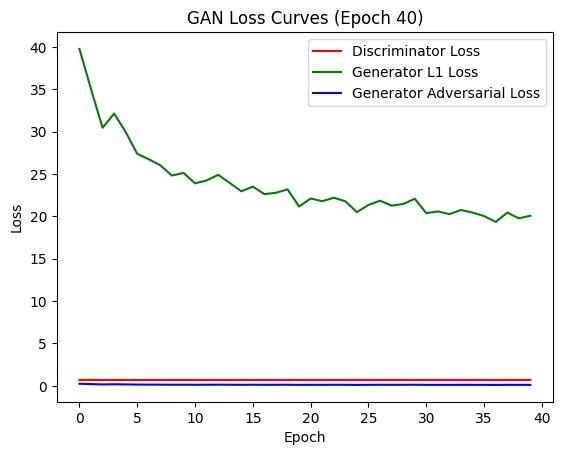

Saved generator weights at ./checkpoints/generator_0040.h5
Epoch 41/50
1/1 [==============================] - 0s 42ms/step
Discriminator loss: 0.6930, Generator L1 loss: 20.3193, Generator adversarial loss: 0.1152
graph_disc_loss [] -  [0.6906642019748688, 0.6918265253305436, 0.6919991403818131, 0.6917763769626617, 0.692221787571907, 0.6923738956451416, 0.6924831122159958, 0.6926120519638062, 0.6927804738283158, 0.6922833770513535, 0.6928440719842911, 0.6927037924528122, 0.6928390979766845, 0.692807424068451, 0.6928660839796066, 0.6928506463766098, 0.6928513497114182, 0.6929985791444778, 0.692814189195633, 0.692870357632637, 0.692996370792389, 0.6928769081830979, 0.6928954958915711, 0.6929234832525253, 0.6929999977350235, 0.6929589241743088, 0.6928619682788849, 0.6929273158311844, 0.6929279953241348, 0.6928247302770615, 0.6931536585092545, 0.6928016632795334, 0.6930829226970673, 0.6927803784608841, 0.6928333193063736, 0.692894971370697, 0.6930884957313538, 0.6929288685321808, 0.6929892

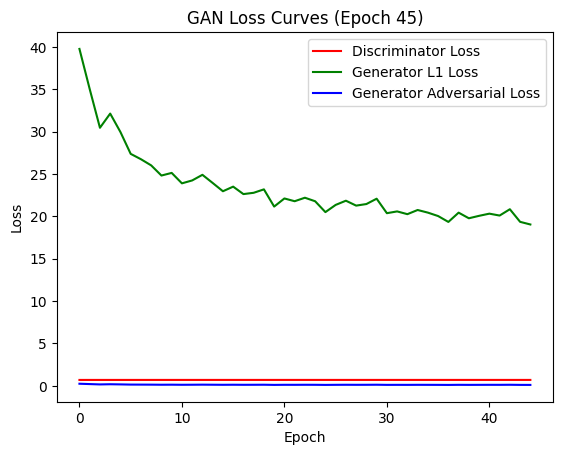

Saved generator weights at ./checkpoints/generator_0045.h5
Epoch 46/50
1/1 [==============================] - 0s 25ms/step
Discriminator loss: 0.6930, Generator L1 loss: 18.5780, Generator adversarial loss: 0.1004
graph_disc_loss [] -  [0.6906642019748688, 0.6918265253305436, 0.6919991403818131, 0.6917763769626617, 0.692221787571907, 0.6923738956451416, 0.6924831122159958, 0.6926120519638062, 0.6927804738283158, 0.6922833770513535, 0.6928440719842911, 0.6927037924528122, 0.6928390979766845, 0.692807424068451, 0.6928660839796066, 0.6928506463766098, 0.6928513497114182, 0.6929985791444778, 0.692814189195633, 0.692870357632637, 0.692996370792389, 0.6928769081830979, 0.6928954958915711, 0.6929234832525253, 0.6929999977350235, 0.6929589241743088, 0.6928619682788849, 0.6929273158311844, 0.6929279953241348, 0.6928247302770615, 0.6931536585092545, 0.6928016632795334, 0.6930829226970673, 0.6927803784608841, 0.6928333193063736, 0.692894971370697, 0.6930884957313538, 0.6929288685321808, 0.6929892

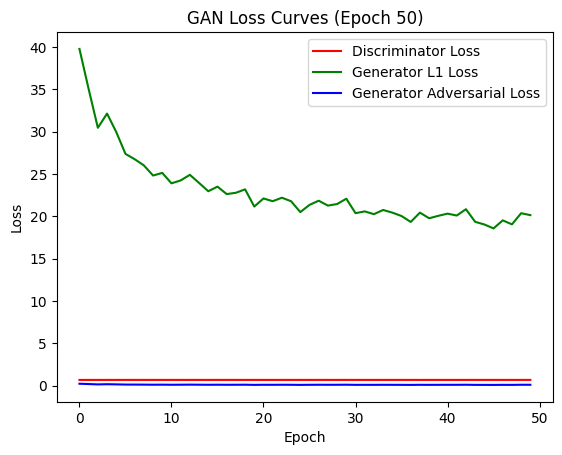

Saved generator weights at ./checkpoints/generator_0050.h5


In [17]:
import math

num_epochs = 50
steps_per_epoch = math.ceil(10000 / 1000)
train_gan(train_gen, val_gen, num_epochs, steps_per_epoch)

**EVALUATION**

In [18]:
import tensorflow as tf
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define custom objects for loading model
# custom_objects = {'tf': tf}

# Load saved model
# model_path = '/content/drive/My Drive/DehazeModels/generator_0010.h5'
# model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

# weights_path = '/content/drive/MyDrive/DehazeModels/Trianed_Indoor_Outdoor/generator_0095.h5'
weights_path = '/content/checkpoints/generator_0050.h5'
# weights_path = '/content/generator_0100.h5'
generator.load_weights(weights_path)

# Define path to test image
# image_path = '/content/yasas.jpg'
# image_path = '/content/haze/0468_1_0.16.jpg'
image_path = '/content/haze/0469_0.85_0.2.jpg'
# image_path = '/content/drive/MyDrive/Test_Images/0471_0.95_0.2.jpg'
# image_path = '/content/drive/MyDrive/Test_Images/1000_10_0.74905.png'
# image_path = '/content/drive/MyDrive/Test_images/1000_1_0.99837.png'

# image_path = '/content/Input/1000_10_0.74905.png'

# Evaluate image using the loaded model
# evaluation(generator, image_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import numpy as np
import tensorflow as tf
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Load a hazy image
input_image_path = image_path
hazy_image = Image.open(input_image_path)

# Preprocess the hazy image
hazy_image = hazy_image.resize((256, 256))  # Resize the image to match the generator input size
hazy_image = np.array(hazy_image) / 127.5 - 1.0  # Scale pixel values to the range [-1, 1]
hazy_image = np.expand_dims(hazy_image, axis=0)  # Add a batch dimension

# Pass the preprocessed image through the generator
dehazed_image = generator.predict(hazy_image)

# Post-process the dehazed image
dehazed_image = np.squeeze(dehazed_image)  # Remove the batch dimension
dehazed_image = (dehazed_image + 1.0) * 127.5  # Rescale pixel values to the range [0, 255]
dehazed_image = np.clip(dehazed_image, 0, 255).astype(np.uint8)  # Clip values and convert to uint8

# Display or save the dehazed image
output_image_path = '/content/output-out.jpg'
# output_image_path = '/content/output-indoor.png'
Image.fromarray(dehazed_image).save(output_image_path)

# Load the hazy and dehazed images as arrays
hazy_image = np.array(Image.open(input_image_path).resize((256, 256)))
dehazed_image = np.array(Image.open(output_image_path))

clear_img_path = '/content/clear_images/0469.jpg'
clear_image = np.array(Image.open(clear_img_path).resize((256, 256)))

# # Calculate the PSNR and SSIM scores
psnr = peak_signal_noise_ratio(clear_image, dehazed_image)
ssim = structural_similarity(clear_image, dehazed_image, multichannel=True)

# # Print the scores
print('PSNR:', psnr)
print('SSIM:', ssim)

1/1 [==============================] - 0s 474ms/step
PSNR: 17.48730758229176
SSIM: 0.6420695677376295


<ipython-input-19-500647782e30>:37: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(clear_image, dehazed_image, multichannel=True)
